# SWAN declarative example

In this notebook we will run SWAN entirely from a model runtime and config entirely
declared in a yaml file. We only plot some model settings to visualise before creating
the model workspace

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import yaml

import warnings
warnings.filterwarnings('ignore')

## Instantiate model

Use a fully-defined config from yaml to instantiate ModelRun with the runtime parameters
and the config definition

In [2]:
# Uncoment below to view the contents of the yaml file

# !cat example_declarative.yml

In [3]:
from rompy.model import ModelRun

conf = yaml.load(open("example_declarative.yml"), Loader=yaml.Loader)
run = ModelRun(**conf)
run

windgrowth
quadrupl
wcapping
breaking
refrac
fshift
bndchk


ModelRun(run_id='run1', period=TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=3600), include_end=True), output_dir='example_declarative', config=SwanConfigComponents(model_type='swanconfig', template='/source/csiro/rompy/rompy/templates/swancomp', checkout='main', cgrid=REGULAR(model_type='regular', spectrum=SPECTRUM(model_type='spectrum', mdc=36, flow=0.04, fhigh=1.0, msc=None, dir1=None, dir2=None), grid=GRIDREGULAR(model_type='gridregular', xp=110.0, yp=-35.2, alp=4.0, xlen=7.5, ylen=12.5, mx=14, my=24, suffix='c')), startup=STARTUP(model_type='startup', project=PROJECT(model_type='project', name='Test declarative', nr='run1', title1='Declarative definition of a Swan config with rompy', title2=None, title3=None), set=SET(model_type='set', level=0.0, nor=None, depmin=0.05, maxmes=None, maxerr=1, grav=9.81, rho=1025.0, cdcap=0.0025, inrhog=None, hsrerr=None, directio

### QC config

Plot model grid and data to QC before generating the workspace

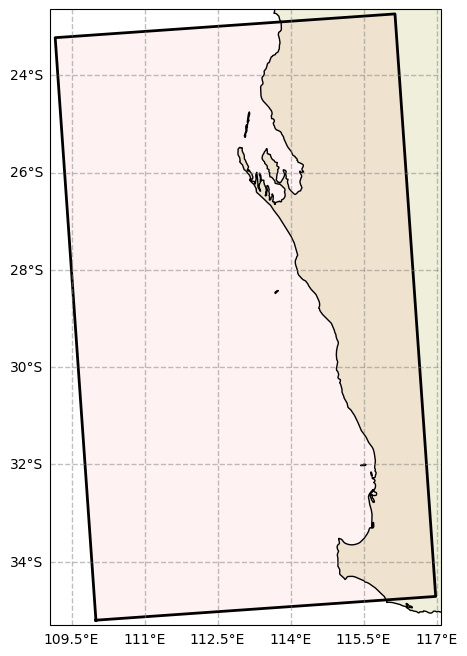

In [14]:
# Model grid

fig, ax = run.config.grid.plot(fscale=8)

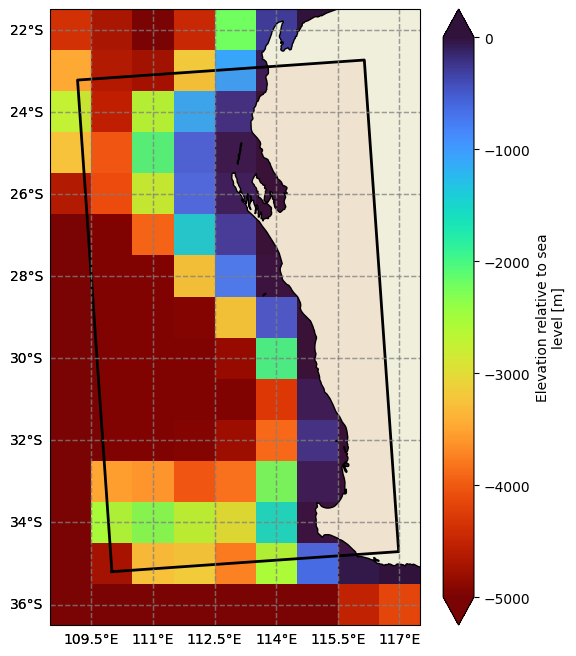

In [15]:
# Model bathy

bottom = run.config.inpgrid.bottom
bottom._filter_grid(run.config.grid) # This isn't necessary since cropping is done by the SwanConfigComponents, it is just for plotting
fig, ax = bottom.plot(param="elevation", vmin=-5000, vmax=0, cmap="turbo_r", figsize=(6, 8))
fig, ax = run.config.grid.plot(ax=ax)

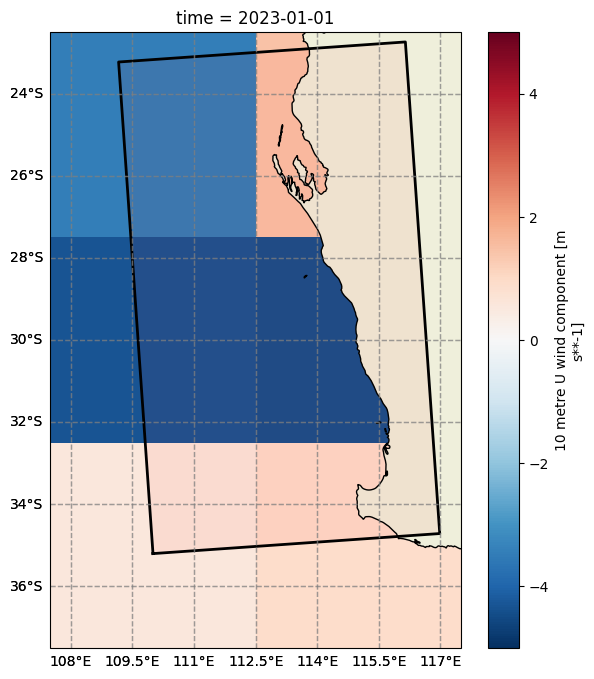

In [17]:
# Model winds

wind = run.config.inpgrid.input[0]
wind._filter_grid(run.config.grid) # This isn't necessary since cropping is done by the SwanConfigComponents, it is just for plotting
fig, ax = wind.plot(param="u10", isel={"time": 0}, vmin=-5, vmax=5, cmap="RdBu_r", figsize=(7, 8))
fig, ax = run.config.grid.plot(ax=ax)

## Run the model

In [7]:
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: run1
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: example_declarative
config: <class 'rompy.swan.config.SwanConfigComponents'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example_declarative
INFO:rompy.swan.data:	Writing bottom to example_declarative/run1/bottom.grd
INFO:rompy.swan.data:	Writing wind to example_declarative/run1/wind.grd
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in example_declarative
INFO:rompy.model:-----------------------------------------------------


'/source/csiro/rompy/notebooks/swan/example_declarative/run1'

### Check the workspace

In [8]:
list((Path(run.output_dir) / run.run_id).glob("*"))

[PosixPath('example_declarative/run1/bottom.grd'),
 PosixPath('example_declarative/run1/INPUT'),
 PosixPath('example_declarative/run1/wind.grd')]

In [9]:
input = Path("example_declarative/run1/INPUT")
print(input.read_text())

! Rompy SwanConfig
! Template: /source/csiro/rompy/rompy/templates/swancomp
! Generated: 2023-10-16 03:01:46.947023 on rafael-XPS by rguedes


! Startup -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PROJECT name='Test declarative' nr='run1' title1='Declarative definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 maxerr=1 grav=9.81 rho=1025.0 cdcap=0.0025 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM

! Computational Grid --------------------------------------------------------------------------------------------------------------------------------------------------------------


CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.5 ylenc=12.5 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0

! Input Grids ---------------------------------------------------------------------------------------------------------------------------

## Run the model

Todo

## Plot outputs

Todo